In [10]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import pandas as pd 
import numpy.random as r 

df_raw = pd.read_csv('data/gm_dataset_Knauer_et_al_2022.csv', decimal=',', sep=';')

# Data by Knauer et al. (2022)
# Available at: N:\SCI-NBI-Trusina\Teresa\DIRECTION\Stillits-model\data\19681410

# print number of unique species and plat functional types
print('Number of data points:', len(df_raw))
print('Number of unique species:', df_raw['species'].nunique())
print('Number of unique plant functional types:', df_raw['plant_functional_type'].nunique())


Number of data points: 1883
Number of unique species: 617
Number of unique plant functional types: 13


In [11]:
def devices(df):
    if 'device_gas_exchange' in df.columns:
        # extract the unique 'device_gas_exchange' values and sort them by frequency but disregard 'nan' and empty
        device_gas_exchange = df['device_gas_exchange'].dropna().unique()
        device_gas_exchange = [x for x in device_gas_exchange if x != '']
        device_gas_exchange.sort(key=lambda x: df['device_gas_exchange'].value_counts()[x], reverse=True)
        # print the sorted unique values
        print('Unique device_gas_exchange values sorted by frequency:    (out of {})'.format(len(df)))
        for value in device_gas_exchange:
            print(value, df['device_gas_exchange'].value_counts()[value])
    else:
        print('No device_gas_exchange column found in the DataFrame.')

devices(df_raw)

Unique device_gas_exchange values sorted by frequency:    (out of 1883)
LI-6400 750
LI-6400XT 528
GFS-3000 134
CIRAS-2 48
GFS 3000 33
LI-6800 20
Li-6400XT 20
LI-6400XTR 14
CIRAS-3 13
LI-6400-40 8
LI-6400xt 7
LCpro+ 7
CIRAS-2, PP Systems 6
CIRAS-1 6
Li 6400 XTP 5
Lcpro+ 5
LI-6400LCF 4
LSC-2 4
LI-6200 3
CIRAS 3
LI-6400F 2
LI-6400XTs 2
Analytical Development Co. (ADC) IRGA (225-MK3) 2
LI-7000 2
LI 6200 2
GFS3000 2
LCA-Pro 1
LI-6800-01A 1
Ciras-2 1
CIRAS-2, CIRAS-3 1
ZAP-AZ012 1
GFS-3100 1
LCA2 1
CIRAS-2, CIRAS-4 1
CIRAS 1 1
ADC LC Pro+ 1
CIRAS2 1
CIRAS-5 1
CIRAS-6 1
CIRAS-7 1
Li-6400 1
CIRAS-8 1
CIRAS-4 1
Walz GFS-3000 1
LI-6262 1
LI-6400-XT 1
HCM-1000 1


In [12]:
# We require porosity and some measure of mesophyll thickness to be available
df = df_raw.dropna(subset=['fias_mesophyll'])
df = df.dropna(subset=['T_leaf', 'T_mesophyll'], how='all')
print('Requrering porosity and mesophyll thickness: ')
print('Number of data points:', len(df))
print('Number of unique species:', df['species'].nunique())
print('Number of unique plant functional types:', df['plant_functional_type'].nunique())

# We add a colum for inference of mesophyll thickness
# We calculate the mean fraction T_mesophyll / T_leaf when both are available. 
# This yields ratio = 0.83 +- 0.11 with a pronounced peak
ratios = df['T_mesophyll'].to_numpy() / df['T_leaf'].to_numpy()
ratios = ratios[~np.isnan(ratios)]
mean_ratio = np.mean(ratios)
std_ratio = np.std(ratios)
# print(f'Mean ratio T_mesophyll / T_leaf: {mean_ratio:.3f} ± {std_ratio:.3f}')

# If T_mesophyll is not available, we use the mean ratio to infer it
df.loc[:, 'mesophyll_thickness'] = 0.
for i in df.index.tolist():
    if np.isnan(df.loc[i, 'T_mesophyll']):
        df.loc[i, 'mesophyll_thickness'] = mean_ratio * df.loc[i, 'T_leaf']
    else:
        df.loc[i, 'mesophyll_thickness'] = df.loc[i, 'T_mesophyll']

# We need values for gs_CO2, An, and Ci. We require An to be available and infer the others if missing
df = df.dropna(subset=['An'])
df = df.dropna(subset=['gs_CO2', 'Ca_gas_exchange', 'Ci'], how='all')

# empty columns for filling in
df.loc[:, 'stomatal_conductance'] = np.nan
df.loc[:, 'substomatal_conc'] = np.nan

# If gs_CO2 is not available, we infer it from An, Ca and Ci 
for i in df.index.tolist():
    if np.isnan(df.loc[i, 'gs_CO2']):
        if not np.isnan(df.loc[i, 'An']) and not np.isnan(df.loc[i, 'Ca_gas_exchange']) and not np.isnan(df.loc[i, 'Ci']):
            df.loc[i, 'stomatal_conductance'] = df.loc[i, 'An'] / (df.loc[i, 'Ca_gas_exchange'] - df.loc[i, 'Ci'])
    else:
        df.loc[i, 'stomatal_conductance'] = df.loc[i, 'gs_CO2']

df = df.dropna(subset=['stomatal_conductance'])

# If Ci is not available, we infer it from An, gs_CO2 and Ca
for i in df.index.tolist():
    if np.isnan(df.loc[i, 'Ci']):
        if not np.isnan(df.loc[i, 'An']) and not np.isnan(df.loc[i, 'stomatal_conductance']) and not np.isnan(df.loc[i, 'Ca_gas_exchange']):
            df.loc[i, 'substomatal_conc'] = df.loc[i, 'Ca_gas_exchange'] - df.loc[i, 'An'] / df.loc[i, 'stomatal_conductance']
    else:
        df.loc[i, 'substomatal_conc'] = df.loc[i, 'Ci']

df = df.dropna(subset=['substomatal_conc'])

# Lastly we need the CO2 compensation point. It is rarely quoted in the dataset, but very constant across samples
# We therefore substitute the mean value
mean_compensation = df_raw['Cistar'].mean()
df.loc[:, 'compensation_point'] = mean_compensation

print('After processing to find (gs, An, Ci, C*): ')
print('Number of data points:', len(df))
print('Number of unique species:', df['species'].nunique())
print('Number of unique plant functional types:', df['plant_functional_type'].nunique())

df.to_csv('data/Knauer2022_filtered.csv', index=False, decimal=',', sep=';')


Requrering porosity and mesophyll thickness: 
Number of data points: 218
Number of unique species: 113
Number of unique plant functional types: 9
After processing to find (gs, An, Ci, C*): 
Number of data points: 174
Number of unique species: 88
Number of unique plant functional types: 8


In [13]:
devices(df)

Unique device_gas_exchange values sorted by frequency:    (out of 174)
LI-6400 55
LI-6400XT 44
GFS-3000 28
CIRAS-2 16
LI-6800 2
LI-6200 1
CIRAS-3 1
CIRAS-2, PP Systems 1
CIRAS-5 1
CIRAS-6 1
CIRAS-7 1
CIRAS-8 1
CIRAS-4 1


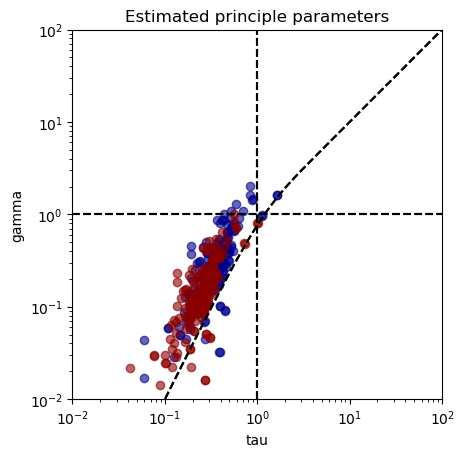

In [14]:
def estimate_conductances(df, rel_error=0.1):
    # we calculate conductances g_ias (Niinemets & Reichstein, 2003) and gm* = An / (Ci - C*)
    diffusivity_in_air = 1.51e-5 # m2/s     CO2 diffusion constant in air at 25 *C (https://pmc.ncbi.nlm.nih.gov/articles/PMC4885940/)
    tortuosity = 1.57 # adopted from Tosens et al. 2012, Syvertsen et al. 1995
    g_ias = (diffusivity_in_air * df["fias_mesophyll"]) / (1e-6 * df["mesophyll_thickness"] * 0.5 * tortuosity) # m/s
    # where we have translated cm2/s to m2/s and um to m
    df.loc[:, 'ias_conductance'] = g_ias / 0.02241  # convert to mol/m2/s to match An in units of umol/m2/s

    gm_star = df['An'] / (df['substomatal_conc'] - df['compensation_point'])  # mol/m2/s
    df.loc[:, 'mesophyll_conductance*'] = gm_star

    # Add relative errors to the conductances for simulated error probagation. Mean estimates are not affected
    df.loc[:, 'd_mesophyll_conductance*'] = rel_error * df['mesophyll_conductance*'] # 10% error
    df.loc[:, 'd_stomatal_conductance'] = rel_error * df['stomatal_conductance'] # 10% error
    df.loc[:, 'd_ias_conductance'] = rel_error * df['ias_conductance'] # 10% error
    return df

# functions for estimating tau, gamma as defined by gs, gias and gm*
def f(gc, gias, gm_):
                return np.sqrt(np.abs(gc*gias/2))*np.tanh(np.sqrt(np.abs(2*gc/gias))) - gm_

def dfdx(gc, gias, gm_):
    return 0.5*(np.sqrt(np.abs(gias/(2*gc)))*np.tanh(np.sqrt(np.abs(2*gc/gias))) + 1/(gias*np.cosh(np.sqrt(np.abs(2*gc/gias)))**2))

def newton(gc0, gias, gm_, step_size = 0.4, max_iterations = 1000, tolerance = 1e-6): #original step_size = 0.1
    gc = gc0
    for i in range(max_iterations):
        f_ = f(gc, gias, gm_)
        if abs(f_) < 1e-6:
            return np.abs(gc)
        df_ = dfdx(gc, gias, gm_)
        if df_ == 0:
            break
        gc = gc - step_size*f_/df_
    print('maxed out all iterations without convergence')

def estimate_principle_parameters(dataframe, sim_samples = 500, plot_sample = False):
    '''
    data_frame: pandas dataframe with columns 'gm_', 'gs', 'g_ias' as well as their errors
    sim_samples: number of samples to draw from the error distributions
    print_example_distributions: if True, will plot example distributions of gamma and tau

    gias is assumed to be defined as D_eff/(0.5*L) as opposed to our own definition lacking the 0.5
    '''
    # unpack data
    # gm* in mol/m2/s
    gm_ = dataframe['mesophyll_conductance*'].to_numpy()
    dgm_ = dataframe['d_mesophyll_conductance*'].to_numpy() 
    # gs in mol/m2/s
    gs = dataframe['stomatal_conductance'].to_numpy()
    dgs = dataframe['d_stomatal_conductance'].to_numpy()
    # gias in mol/m2/s
    gias = dataframe['ias_conductance'].to_numpy()
    dgias = dataframe['d_ias_conductance'].to_numpy()
    # 
    samples = len(gm_) # assume equal for all conductances 
    #
    gammas = np.zeros(samples) # mean
    dgammas = np.zeros((samples,2)) # 16th and 84th percentiles matching +- 1 sigma for a normal distribution
    
    taus = np.zeros(samples)
    dtaus = np.zeros((samples,2))
    
    random_int = r.randint(0,samples) # integer for picking random instance to plot if requested

    for i in tqdm(range(samples)):
        # gamma
        gamma_dist = np.zeros(sim_samples)
        for j in range(sim_samples):
            gs_sim = -1
            while gs_sim <= 0:
                gs_sim = r.normal(gs[i],dgs[i])
            gias_sim = -1
            while gias_sim <= 0:
                gias_sim = r.normal(gias[i],dgias[i])
            gamma_dist[j] = 2*gs_sim/gias_sim
        gammas[i] = np.mean(gamma_dist)
        dgammas[i,0] = np.abs(np.percentile(gamma_dist,16) - gammas[i])
        dgammas[i,1] = np.abs(np.percentile(gamma_dist,84) - gammas[i])
        
        # tau 
        tau_dist = np.zeros(sim_samples)
        for j in range(sim_samples):
            gm_sim = -1
            while gm_sim <= 0:
                gm_sim = r.normal(gm_[i],dgm_[i])
            gias_sim = -1
            while gias_sim <= 0:
                gias_sim = r.normal(gias[i],dgias[i])
            gc0 = gm_[i] # initial guess for gc which will be true in the low tau limit
            gc_sim = newton(gc0, gias_sim, gm_sim)
            tau_dist[j] = np.sqrt(2*gc_sim/gias_sim)
        taus[i] = np.mean(tau_dist)
        dtaus[i,0] = np.abs(np.percentile(tau_dist,16) - taus[i])
        dtaus[i,1] = np.abs(np.percentile(tau_dist,84) - taus[i])

        # plot if requested
        if i == random_int and plot_sample:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            # gamma in ax1
            ax1.hist(gamma_dist, bins=20, color='darkblue');
            ax1.plot([gammas[i], gammas[i]], [0, 100], 'r--')
            ax1.plot([gammas[i] - dgammas[i,0], gammas[i] - dgammas[i,0]], [0, 100], 'g--')
            ax1.plot([gammas[i] + dgammas[i,1], gammas[i] + dgammas[i,1]], [0, 100], 'g--')
            ax1.set_title('Example distribution of individual gamma sim.')
            # tau in ax2
            ax2.hist(tau_dist, bins=20, color='darkblue');
            ax2.plot([taus[i], taus[i]], [0, 100], 'r--')
            ax2.plot([taus[i] - dtaus[i,0], taus[i] - dtaus[i,0]], [0, 100], 'g--')
            ax2.plot([taus[i] + dtaus[i,1], taus[i] + dtaus[i,1]], [0, 100], 'g--')
            ax2.set_title('Example distribution of individual tau sim.')
            plt.show()
    # add to dataframe
    dataframe['gamma'] = gammas
    dataframe['dgamma_low'] = dgammas[:,0]
    dataframe['dgamma_high'] = dgammas[:,1]
    dataframe['tau'] = taus
    dataframe['dtau_low'] = dtaus[:,0]
    dataframe['dtau_high'] = dtaus[:,1]
    #
    return dataframe, (taus, dtaus), (gammas, dgammas)

def example_plot_tau_gamma(df, color='darkblue', show=True):
    taus = df['tau'].to_numpy()
    gammas = df['gamma'].to_numpy()
     # Illustration of the estimated principle parameters
    t = np.linspace(1e-2, 1e2, 1000)
    plt.plot(taus, gammas, 'o', color=color, alpha=0.6)
    plt.plot(t, t*np.tanh(t), 'k--')
    plt.plot([1, 1], [1e-2, 1e2], 'k--')
    plt.plot([1e-2, 1e2], [1, 1], 'k--')
    plt.xlabel('tau')
    plt.ylabel('gamma')
    plt.title('Estimated principle parameters')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-2, 1e2)
    plt.ylim(1e-2, 1e2)
    # force aspect ratio to be equal
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    if show:
        plt.show()

# # Treat all as hypostomatous
# df_hypo = pd.read_csv('data/Knauer2022_filtered.csv', decimal=',', sep=';')
# df_hypo = estimate_conductances(df_hypo, rel_error=0.1)
# df_hypo, (taus_hypo, dtaus_hypo), (gammas_hypo, dgammas_hypo) = estimate_principle_parameters(df_hypo, sim_samples=500, plot_sample=False)
# # Save hypo data
# df_hypo.to_csv('data/Knauer2022_all_hypostomatous.csv', index=False, decimal=',', sep=';')

# # Treat all as amphistomatous
# df_amphi = pd.read_csv('data/Knauer2022_filtered.csv', decimal=',', sep=';')
# df_amphi['mesophyll_thickness'] = df_amphi['mesophyll_thickness'] / 2 # halve mesophyll thickness to account for equal amphistomatous case
# df_amphi = estimate_conductances(df_amphi, rel_error=0.1)
# df_amphi, (taus_amphi, dtaus_amphi), (gammas_amphi, dgammas_amphi) = estimate_principle_parameters(df_amphi, sim_samples=500, plot_sample=False)
# # Save amphistomatous data
# df_amphi.to_csv('data/Knauer2022_all_amphistomatous.csv', index=False, decimal=',', sep=';')

df_hypo = pd.read_csv('data/Knauer2022_all_hypostomatous.csv', decimal=',', sep=';')
df_amphi = pd.read_csv('data/Knauer2022_all_amphistomatous.csv', decimal=',', sep=';')

# Plot example distributions of tau and gamma
example_plot_tau_gamma(df_hypo, color='darkblue', show=False)
example_plot_tau_gamma(df_amphi, color='darkred', show=True)


In [15]:
df_filtered = df_hypo[['species', 'plant_functional_type', 'device_gas_exchange', 'tau', 'gamma']]
df_filtered = df_filtered[(df_filtered['tau'] > 0.5) & (df_filtered['gamma'] > 0.5)]
df_filtered= df_filtered[df_filtered['device_gas_exchange'] == 'LI-6400XT']  # filter for LI-6400XT device
df_filtered['species'].unique()

array(['Arabidopsis thaliana', 'Oryza sativa'], dtype=object)

In [ ]:
df_filtered = df_hypo[['species', 'plant_functional_type', 'tau', 'gamma']]
df_filtered = df_filtered[(df_filtered['tau'] > 0.5) & (df_filtered['gamma'] > 0.5)]
df_filtered.loc[:, 'hypostomatous'] = 'yes'
for i in df_filtered.index.tolist():
    if df_filtered.loc[i, 'species'] == 'Gossypium hirsutum':
        df_filtered.loc[i, 'hypostomatous'] = 'no'
    elif df_filtered.loc[i, 'species'] == 'Oryza sativa':
        df_filtered.loc[i, 'hypostomatous'] = 'no'
    elif df_filtered.loc[i, 'species'] == 'Arabidopsis thaliana':
        df_filtered.loc[i, 'hypostomatous'] = 'no'

df_filtered.to_csv('data/Knauer2022_top9_tau_gamma.csv', index=False, decimal=',', sep=';')
df_filtered.head(100)

,species,plant_functional_type,tau,gamma,hypostomatous
2,Abies pinsapo,evergreen gymnosperms,1.654103,1.606955,yes
3,Abies pinsapo,evergreen gymnosperms,1.639703,1.602612,yes
4,Abies pinsapo,evergreen gymnosperms,1.119772,0.971910,yes
5,Abies pinsapo,evergreen gymnosperms,1.127129,0.969050,yes
11,Arabidopsis thaliana,C3 annual herbaceous,0.519883,0.695751,no
28,Cupressus sempervirens,evergreen gymnosperms,0.886504,1.426842,yes
29,Cupressus sempervirens,evergreen gymnosperms,0.894296,1.456548,yes
44,Gossypium hirsutum,C3 perennial herbaceous,0.561017,0.676203,no
46,Gossypium hirsutum,C3 perennial herbaceous,0.558749,0.665846,no
47,Gossypium hirsutum,C3 perennial herbaceous,0.535604,0.736027,no


In [ ]:
cf = pd.read_csv('data/Knauer2022_top9_classification.csv', index_col=0)
cf.head(10)

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
species;plant_functional_type;mean_tau;mean_gamma,,,,,,,,
Abies pinsapo;evergreen gymnosperms;1,3851769417247612;1,2.876320e+15,25,"Peguero-Pina et al. 2012 (Plant Cell Environ.,...",NaN,NaN,NaN,NaN
Cupressus sempervirens;evergreen gymnosperms;0,8904003016551738;1,4.416950e+15,1,https://sjuoz.uoz.edu.krd/index.php/sjuoz/arti...,NaN,NaN,NaN,NaN
Quercus ilex;evergreen angiosperms;0,6992708387185006;1,3.255200e+15,1,NaN,NaN,NaN,NaN,Influence of Environmental Factors and Air Com...
Oryza sativa;C3 annual herbaceous;0,6245583288617719;0,9.104830e+15,2,https://www.mdpi.com/2223-7747/12/1/66,NaN,NaN,NaN,NaN
Quercus coccifera;evergreen angiosperms;0,5902732124111794;1,2.835020e+15,1,https://www.mdpi.com/2223-7747/13/20/2867,NaN,NaN,NaN,NaN
Quercus suber;evergreen angiosperms;0,5537984328860011;0,7.917100e+15,1,assumed to be the same as Quercus ilex/coccifera,NaN,NaN,NaN,NaN
Gossypium hirsutum;C3 perennial herbaceous;0,548295431836554;0,6.997910e+15,2,https://www.sciencedirect.com/science/article/...,NaN,NaN,NaN,NaN
Arabidopsis thaliana;C3 annual herbaceous;0,5198832706409048;0,6.957510e+15,2,NaN,NaN,NaN,NaN,NaN
Quercus wislizeni;evergreen angiosperms;0,5170907642707839;1,9.237850e+14,1,assumed to be the same as Quercus ilex/coccifera,NaN,NaN,NaN,NaN
